# Dataset 3 - PMC Open Access Subset
https://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_bulk/oa_comm/txt/

**Research Question:** Can clustering techniques reveal significant patterns and themes in the research abstracts related to public health?

**Method:** KDD

**Analysis:** K-Means Clustering, LDA

In [1]:
# import relevant libraries for data analysis and visualisations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("white")

### Abstract Extraction

In [2]:
# import relevant libraries for file and data manipulation
import os
import re

In [3]:
# function to extract abstract from a research paper text file
def extract_abstract(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # abstract detection patterns
        abstract_patterns = [
            # pattern 1 - match text starting with "Abstract" until intro or other sections
            r'Abstract[:\n\s]*(.+?)(?:\n\n|\n[A-Z]|\n1\.|\nIntroduction|\nMethods)',
            # pattern 2 - match common sentence structures for abstracts
            r'((?:The|This|Our|A)\s[^.\n]{50,250}(?:\.|\n)(?:\s*[^.\n]{50,250}\.)*)',
        ]
        
        # run each file through pattern recognition to extract relevant text
        for pattern in abstract_patterns:
            match = re.search(pattern, content, re.DOTALL | re.IGNORECASE)
            if match:
                abstract = match.group(1).strip() #  get matched abstract text
                # further cleaning
                abstract = re.sub(r'\s+', ' ', abstract) # remove extra whitespace
                abstract = re.sub(r'^(Abstract:?\s*)', '', abstract, flags=re.IGNORECASE)
                # ensure minimum and maximum length
                if 50 < len(abstract) < 1000:
                    return abstract
        return ""
    except Exception as e:
        # handle any error during file reading or regex matching
        print(f"Error processing {file_path}: {e}")
        return ""

# extract abstracts from all text files in directory
def batch_extract_abstracts(directory):
    cleaned_abstracts = [] # list to store cleaned and processed abstracts
    # process every text file present in directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            abstract_text = extract_abstract(file_path)
            if abstract_text:
                cleaned_abstracts.append(abstract_text)
    return cleaned_abstracts # return list containing cleaned abstracts

# set up working directory and run extractor
directory = os.getcwd()+"\\PMC011xxxxxx"
abstracts = batch_extract_abstracts(directory)

In [4]:
# analyse number of extracts in list
print(f"There are currently {len(abstracts)} abstracts under analysis.")

There are currently 11947 abstracts under analysis.


In [5]:
# remove abstracts with less than 40 words
for abs in abstracts:
    if len(abs.split(' ')) < 40:
        abstracts.remove(abs)

In [6]:
# analyse number of extracts in list
print(f"There are currently {len(abstracts)} abstracts under analysis.")

There are currently 6174 abstracts under analysis.


### Text Analytics and Processing

In [7]:
# import relevant libraries for text preprocessing
import string
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#### Text Cleaning

In [8]:
# precompile regex patterns for efficiency
url_pattern = re.compile(r'https?://\S+|www\.\S+') # pattern to match URLs (http/https and www)
email_pattern = re.compile(r'\S+@\S+') # pattern to match email addresses
number_pattern = re.compile(r'\d+') # pattern to match numbers

# initialize lemmatization for word normalization
lemmatizer = WordNetLemmatizer()

# Improved irrelevant terms list using a set for faster lookups (including multi-word phrases)
irrelevant_terms = set([
    'article', 'attribution', 'commons', 'creative', 'licensed', 'university', 
    'study', 'writing', 'common', 'creative common', 'review', 'term', 'original', 
    'license', 'doi', 'journal', 'conference', 'methodology', 'results', 'introduction',
    'abstract', 'experiment', 'research', 'finding', 'paper', 'researcher', 'data',
    'analysis', 'method', 'approach', 'study', 'objective', 'hypothesis', 'author', 
    'result', 'conclusion', 'work', 'contribution', 'impact', 'publication', 'reviewer',
    'peer', 'editor', 'sampling', 'sampling', 'dataset', 'publication', 'factor', 
    'variable', 'test', 'measure', 'statistic', 'response', 'condition'
])

# function to carry out extensive cleaning too abstract text
def preprocess_text(text):
    # remove irrelevant terms
    text = ' '.join([word for word in text.split() if word.lower() not in irrelevant_terms])
    # normalize unicode characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    # remove URLs
    text = url_pattern.sub('', text)
    # remove email addresses
    text = email_pattern.sub('', text)
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = number_pattern.sub('', text)
    # tokenize
    tokens = word_tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # remove special characters
    tokens = [token for token in tokens if token.isalnum()]
    # lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# store processed text into list
preprocessed_abstracts = [preprocess_text(text) for text in abstracts]

#### Text Analytics

In [9]:
# import relevant libraries for text analytics and machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

In [10]:
# vectorize using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(preprocessed_abstracts)

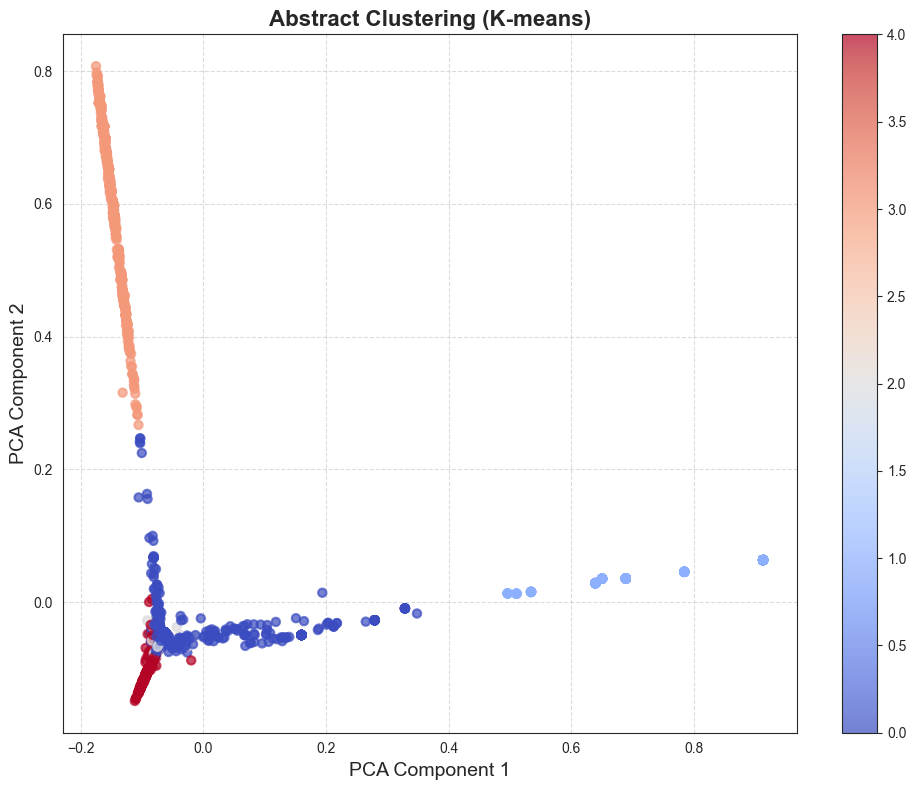

In [11]:
# KMeans clustering
num_clusters = 5 # number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X) # fit KMeans model

# PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# visualize clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='coolwarm', alpha=0.7, linewidth=1.5)
plt.title('Abstract Clustering (K-means)', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.colorbar()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Topic #0:
commercial purpose form including maintained integrity reuse broadest provided poland

Topic #1:
open access term distributed cc condition ccby chengdu license jilin

Topic #2:
patient cancer effect cell cohort adult lung treatment association type

Topic #3:
state united science china center spain usa beijing chinese institute

Topic #4:
gene novel potential network model new based cell protein disease

Topic #5:
china hospital university affiliated medical central people model material key

Topic #6:
draft editing curation investigation conceptualization formal visualization validation supervision administration

Topic #7:
department medicine science university institute medical usa school college health

Topic #8:
use distribution reproduction permitted term credited provided trial cited practice

Topic #9:
case study article report included search patient criterion inclusion text



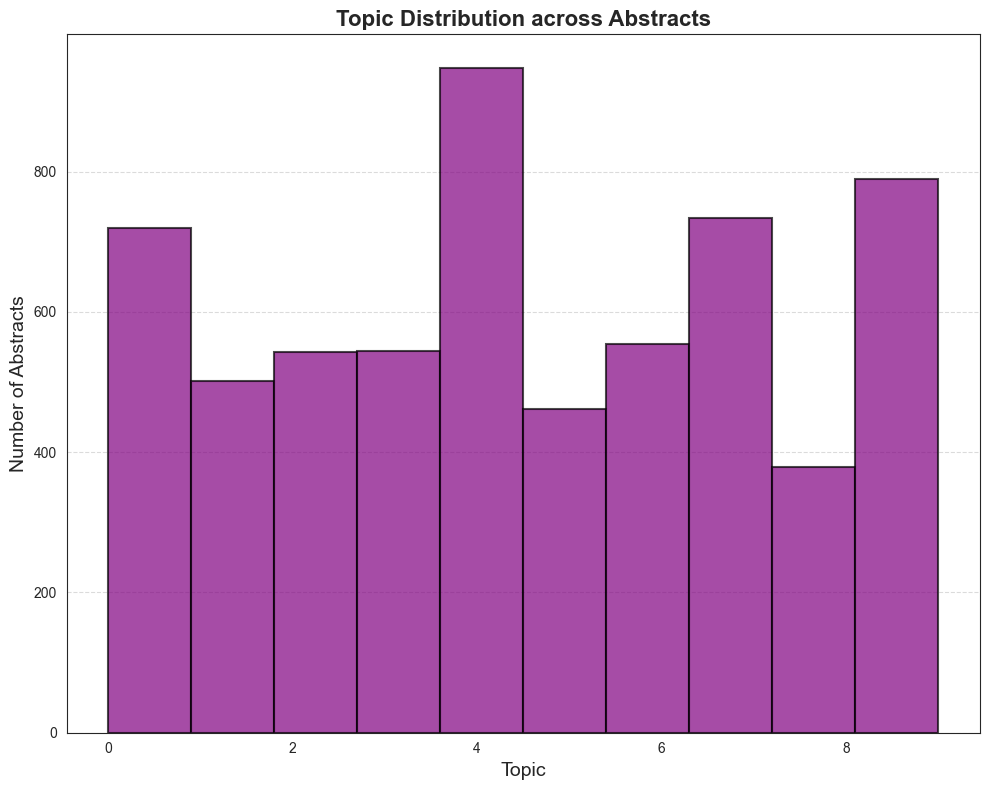

In [12]:
# apply LDA for topic modeling
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# display topics and top words in each topic
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-11:-1]]))
    print()

# assign each abstract to a topic and visualize
topic_dist = lda.transform(X)
topic_labels = topic_dist.argmax(axis=1)

# visualize topic distribution across abstracts
plt.figure(figsize=(10, 8))
plt.hist(topic_labels, bins=num_topics, edgecolor='black', color='purple', alpha=0.7, linewidth=1.5)
plt.title('Topic Distribution across Abstracts', fontsize=16, fontweight='bold')
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Number of Abstracts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
# vectorize abstracts with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10)
X = vectorizer.fit_transform(preprocessed_abstracts)

# get top key phrases (unigrams + bigrams)
feature_names = vectorizer.get_feature_names_out()
top_keywords = [feature_names[i] for i in X.sum(axis=0).argsort()[0, ::-1]]

print(f"Top 10 Keywords/Phrases: {top_keywords}")

Top 10 Keywords/Phrases: [array([['china', 'term', 'study', 'distributed', 'open',
        'distributed term', 'access', 'open access',
        'access distributed', 'cc']], dtype=object)]


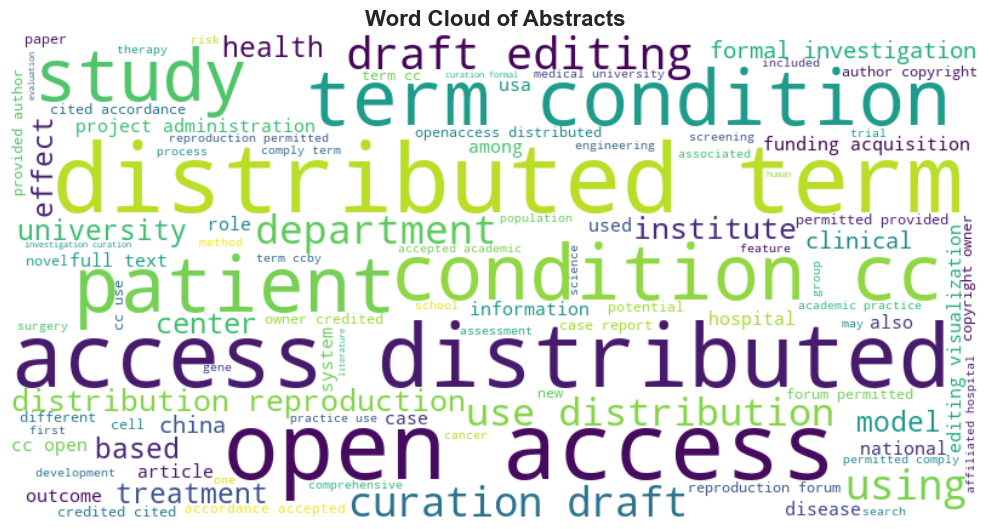

In [14]:
# combine preprocessed abstracts into single text block
all_abstracts = ' '.join(preprocessed_abstracts)

# generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, stopwords='english', background_color='white').generate(all_abstracts)

# plot word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Abstracts', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()